In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import numpy as np
from gymnax.visualize import GymAnimator

rng = jax.random.PRNGKey(0)
rng, rng_net = jax.random.split(rng)

# Define policy to rollout (Random Init MLP)

In [2]:
# Define helper FFW network
def init_policy_mlp(rng_input, sizes, scale=1e-2):
    """ Initialize the weights of all layers of a relu + linear layer """
    # Initialize a single layer with Gaussian weights - helper function
    def initialize_layer(m, n, key, scale):
        w_key, b_key = jax.random.split(key)
        return (scale * jax.random.normal(w_key, (n, m)),
                scale * jax.random.normal(b_key, (n,)))

    keys = jax.random.split(rng_input, len(sizes)+1)
    W1, b1 = initialize_layer(sizes[0], sizes[1], keys[0], scale)
    W2, b2 = initialize_layer(sizes[1], sizes[2], keys[1], scale)

    params = {"layer_in": {"W1": W1, "b1": b1},
              "layer_out": {"W2": W2, "b2": b2}}
    return params

def ffw_policy(params, obs):
    """ Compute forward pass and return action from deterministic policy """
    def relu_layer(W, b, x):
        """ Simple ReLu layer for single sample """
        return jnp.maximum(0, (jnp.dot(W, x) + b))
    # Simple single hidden layer MLP: Obs -> Hidden -> Action
    activations = relu_layer(params["layer_in"]["W1"],
                             params["layer_in"]["b1"], obs)
    mean_policy = jnp.dot(params["layer_out"]["W2"],
                          activations) + params["layer_out"]["b2"]
    return mean_policy

policy_params = init_policy_mlp(rng_net, sizes=[3, 16, 1])

# Rollout and animate policy on Pendulum-v0

In [3]:
animator = GymAnimator(ffw_policy, policy_params, 'Pendulum-v0')

Finished rolling out agent & collecting frames.
Finished processing frames to .gif.


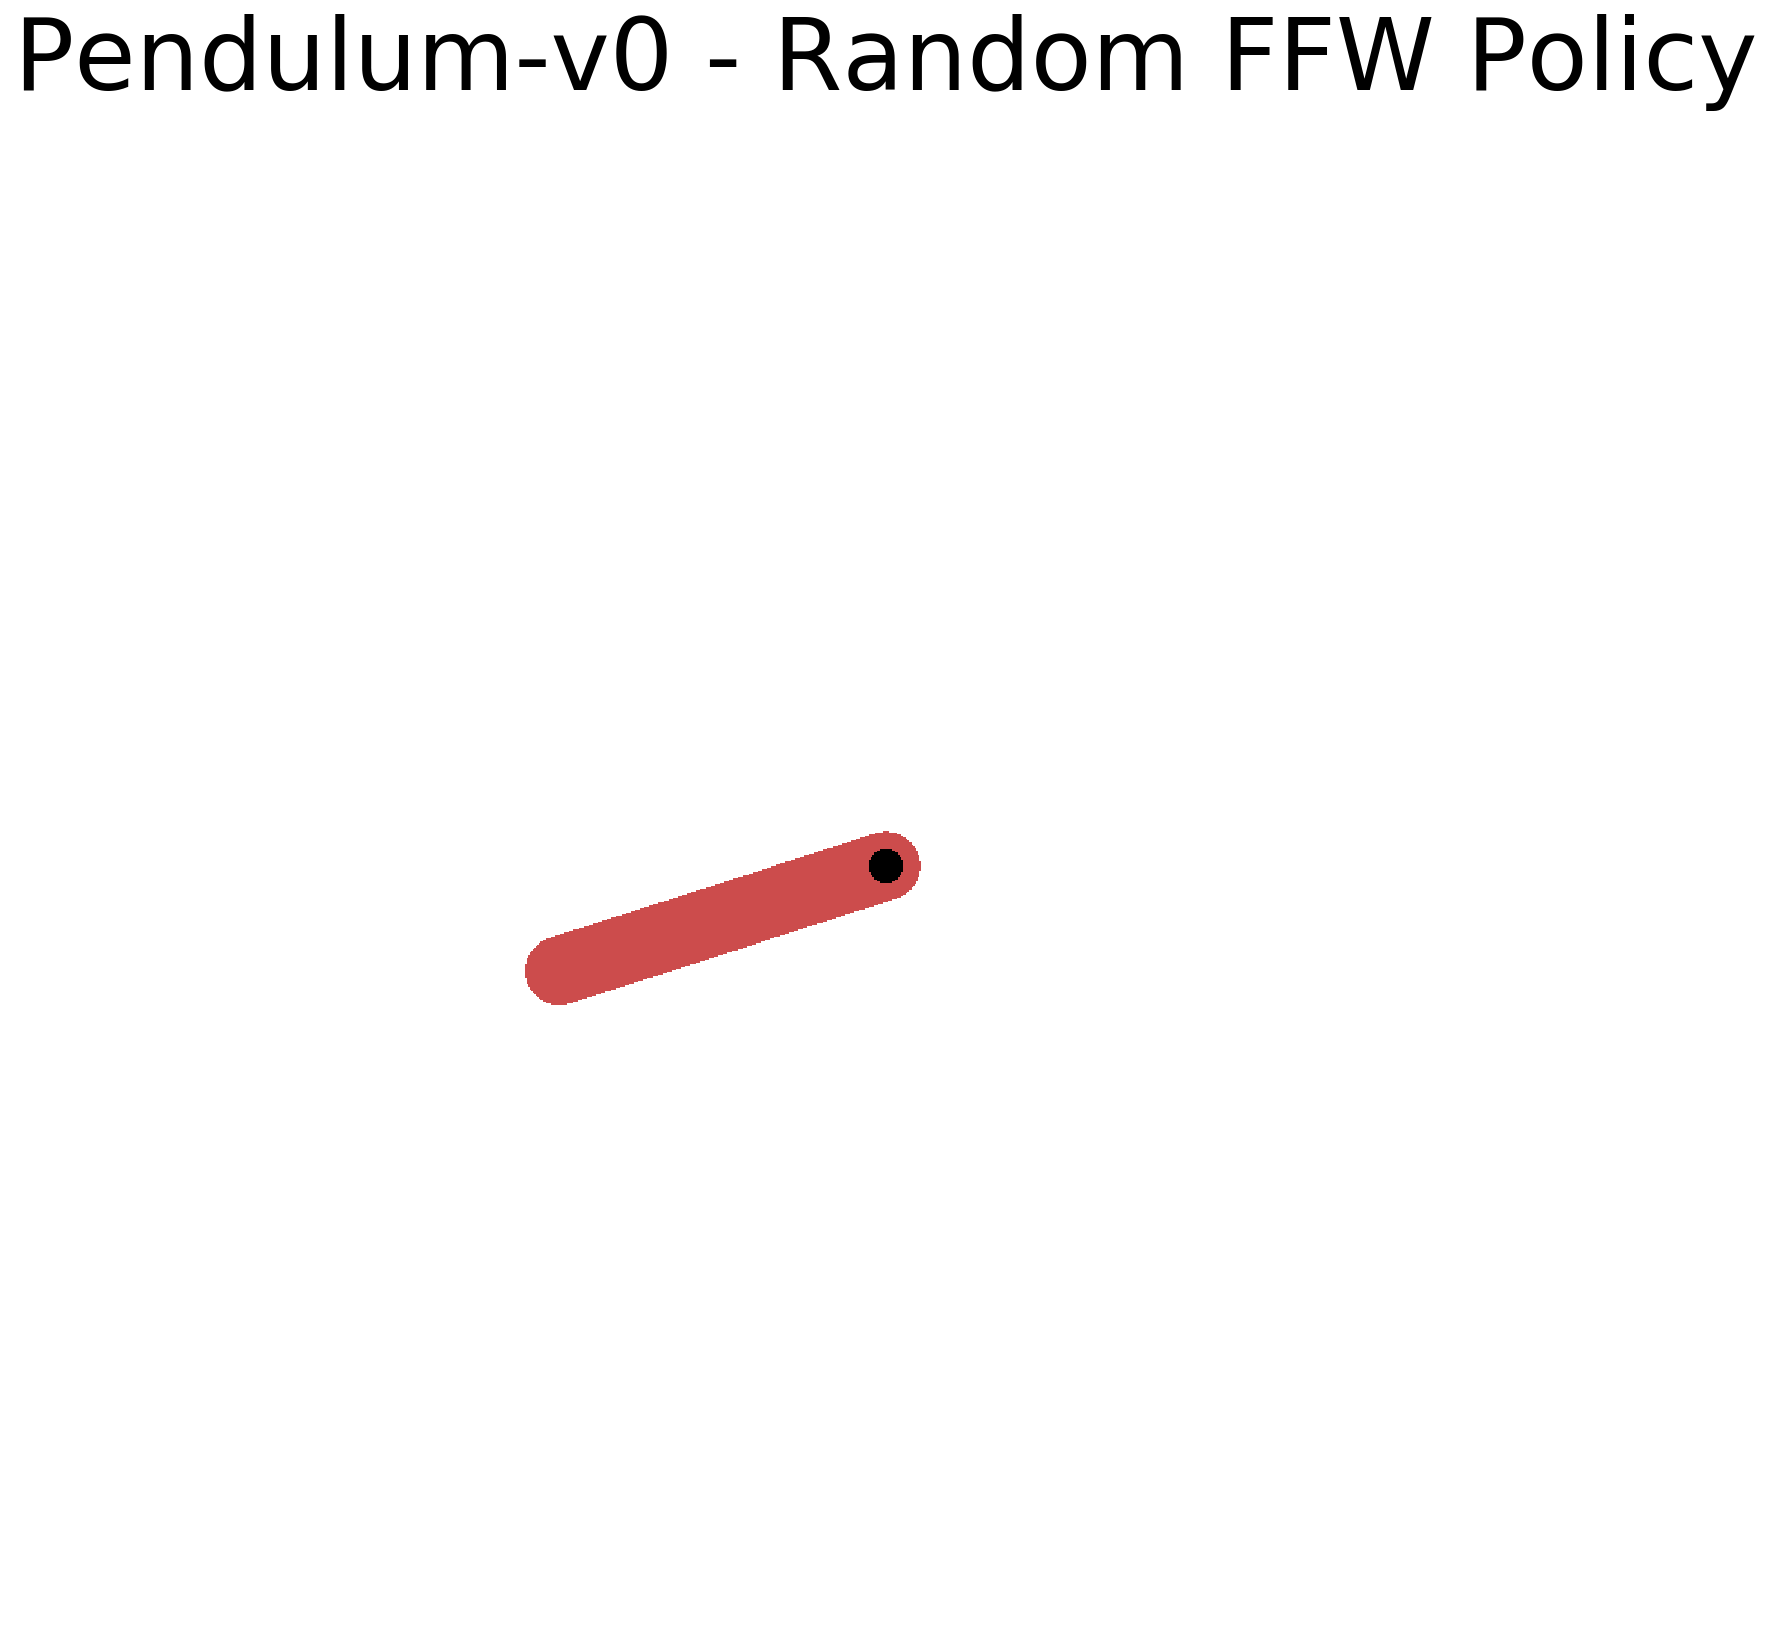

In [4]:
animator.rollout_and_animate(num_steps=200, title="Pendulum-v0 - Random FFW Policy",
                             filename="test_pendulum_anim.gif")